In [14]:
import numpy as np
import matplotlib.pyplot as plt


# Parse measurements from file

data = {"ch1": [], "ch3": []}

TIME_DIVISION = 2.5

times = np.arange(1024)*TIME_DIVISION

with open("Data_received/Run_10k.dat") as file:

    # skip file header
    file.readline()
    file.readline()
    file.readline()
    file.readline()

    while True:


        # skip event header and check end of file
        if not file.readline(): break
        file.readline()

        # skip channel 1 header
        file.readline()

        ch1_vals = file.readline()
        ch1_vals = list(map(lambda x: -float(x), ch1_vals.split()))
        data["ch1"].append(np.array(ch1_vals))

        # skip channel 2 header
        file.readline()

        ch3_vals = file.readline()
        ch3_vals = list(map(lambda x: -float(x), ch3_vals.split()))
        data["ch3"].append(np.array(ch3_vals))

In [15]:

means = []
maxes = []

for arr in data["ch3"]:

    means.append(np.mean(arr))
    maxes.append(np.max(arr))

means = np.array(means)
maxes = np.array(maxes)

plt.hexbin(means, maxes, bins=50)
plt.xlabel("Mean value")
plt.ylabel("Max value")

linDiscr = lambda x: 30*(x-0.02) + 0.2

xDiscr = np.linspace(0.0133333, 0.03, 1000)
yDiscr = linDiscr(xDiscr)

plt.plot(xDiscr, yDiscr, "r")


accepEvents = maxes > linDiscr(means)

dat_aCh3 = np.array(data["ch3"])[accepEvents]

print(dat_aCh3.shape[0])
print(len(data["ch3"]))

print("{:.2f} % of events eliminated".format((1-dat_aCh3.shape[0]/len(data["ch3"]))*100))

937
10000
90.63 % of events eliminated


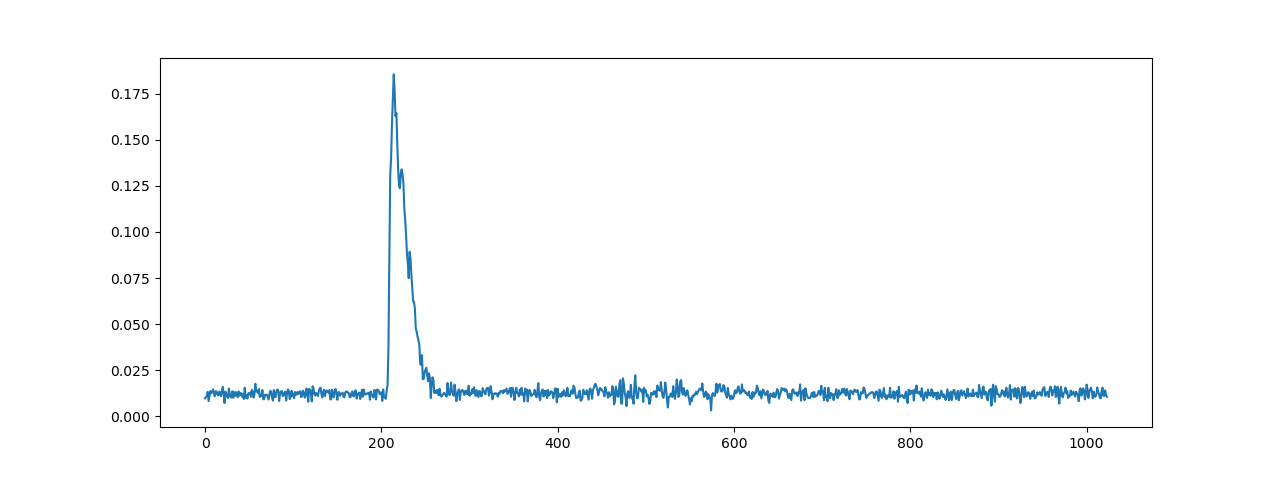

In [16]:
%matplotlib widget

plt.figure(figsize=(6.4*2, 4.8))

plt.plot(dat_aCh3[11])

## Functionality to pergorm fitting

In [17]:
from scipy.optimize import curve_fit

def get_fit_params(sig):

    def fitFunc(t, A0, A1, A2, C4, L1, L2, a, b):

        t_b = t-b

        D = a-b

        C0 = A1+A2+A0
        C1 = -L1*A1-L2*A2
        C3 = C1/D**2 - 2*C4*D + 2*(C0-A0)/D**3
        C2 = (A0 - C0 - C1*D - C3*D**3 - C4*D**4)/D**2

        pol = lambda x: C0 + C1*x + C2*x**2 + C3*x**3 + C4*x**4

        results = np.ones_like(t_b)

        results[t <= a] = A0
        results[(t > a)*(t <= b)] = pol(t_b[(t > a)*(t <= b)])
        results[t > b] = A1*np.exp(-L1*t_b[t > b])+A2*np.exp(-L2*t_b[t > b]) + A0

        return results

    t0 = times[np.argmax(sig)]
    A = np.max(sig)

    L_init = 1/25.0
    b_shift_from_t0 = 5
    a_shift_from_t0 = 15


    a = t0 - a_shift_from_t0
    b = t0 + b_shift_from_t0   
    A0 = np.mean(sig[times < a])
    A1 = 0.7*A*np.exp(-L_init*b_shift_from_t0)
    A2 = 0.3*A*np.exp(-1.3*L_init*b_shift_from_t0) 
    C4 = 0
    L1 = L_init*0.7
    L2 = L_init*1.3

    pars = [A0, A1, A2, C4, L1, L2, a, b]

    bounds = (
        (     0,      0,      0, -np.inf,      0,      0,      0,      0),
        (np.inf, np.inf, np.inf,  np.inf, np.inf, np.inf, np.inf, np.inf) 
    )

    times_trunc = times[(times >= t0-40*TIME_DIVISION)*(times <= t0+100*TIME_DIVISION)]
    sig_trunc = sig[(times >= t0-40*TIME_DIVISION)*(times <= t0+100*TIME_DIVISION)]

    popt, pcov = curve_fit(fitFunc, times_trunc, sig_trunc, p0=pars, bounds=bounds)

    A0, A1, A2, C4, L1, L2, a, b = popt

    result = {
        "A0": A0,
        "A1": A1,
        "A2": A2,
        "C4": C4,
        "L1": L1,
        "L2": L2,
        "a" : a ,
        "b" : b 
        }
    
    return result

def DrawFitFunc(t, A0, A1, A2, C4, L1, L2, a, b):

    t_b = t-b

    D = a-b

    C0 = A1+A2+A0
    C1 = -L1*A1-L2*A2
    C3 = C1/D**2 - 2*C4*D + 2*(C0-A0)/D**3
    C2 = (A0 - C0 - C1*D - C3*D**3 - C4*D**4)/D**2

    pol = lambda x: C0 + C1*x + C2*x**2 + C3*x**3 + C4*x**4
    

    results = {
        "T1": {"X": t[t <= a],           "Y": np.ones_like(t[t <= a])*A0},
        "T2": {"X": t[(t > a)*(t <= b)], "Y": pol(t_b[(t > a)*(t <= b)])},
        "T3": {"X": t[t > b],            "Y": A1*np.exp(-L1*t_b[t > b])+A2*np.exp(-L2*t_b[t > b]) + A0}
    }

    results["T1"]["X"] = np.append(results["T1"]["X"], results["T2"]["X"][0])
    results["T1"]["Y"] = np.append(results["T1"]["Y"], results["T2"]["Y"][0])

    results["T2"]["X"] = np.append(results["T2"]["X"], results["T3"]["X"][0])
    results["T2"]["Y"] = np.append(results["T2"]["Y"], results["T3"]["Y"][0])

    return results

def GetAmpQsQf(A0, A1, A2, C4, L1, L2, a, b):

    amplitude = A1+A2

    if L1 < 0.0001:
        Q1 = 0
    else:
        Q1 = A1/L1
    
    if L2 < 0.0001:
        Q2 = 0
    else:
        Q2 = A2/L2

    Qs = min(Q1, Q2)
    Qf = max(Q1, Q2)

    return amplitude, Qs, Qf

{'A0': 0.013708996508072073, 'A1': 0.14625394519266688, 'A2': 0.21580225594583385, 'C4': -4.436338582111462e-05, 'L1': 0.03713832748126708, 'L2': 0.037135812672636076, 'a': 504.56376353144094, 'b': 518.8798874445918}
amplitude = 0.36205620113850073
Qs = 3.938086475930795
Qf = 5.811162875260034


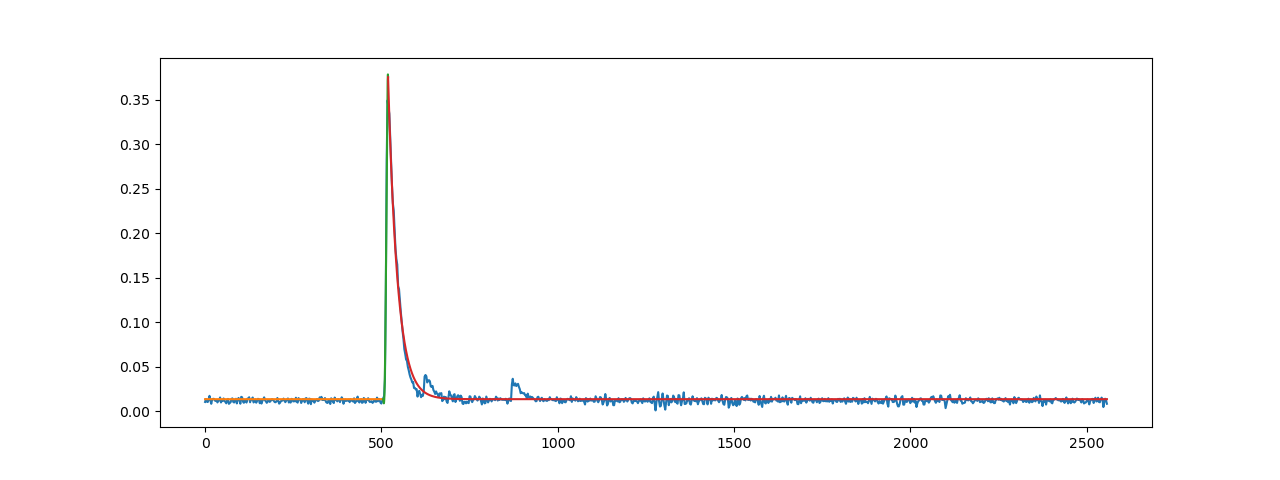

In [23]:
%matplotlib widget

plt.figure(figsize=(6.4*2,4.8))

evt_number = 0

signal = dat_aCh3[evt_number]

plt.plot(times, signal)

fit_params = get_fit_params(signal)

times_extended = np.linspace(times[0], times[-1], times.size*100)

dar_func_d = DrawFitFunc(times_extended, **fit_params)

plt.plot(dar_func_d["T1"]["X"], dar_func_d["T1"]["Y"])
plt.plot(dar_func_d["T2"]["X"], dar_func_d["T2"]["Y"])
plt.plot(dar_func_d["T3"]["X"], dar_func_d["T3"]["Y"])

amplitude, Qs, Qf = GetAmpQsQf(**fit_params)

print(fit_params)

print("amplitude =", amplitude)
print("Qs =",        Qs)
print("Qf =",        Qf)

In [19]:
amp_arr = []
Qs_arr = []
Qf_arr = []

for evt_num in range(dat_aCh3.shape[0]):

    signal = dat_aCh3[evt_num]

    try:

        fit_params = get_fit_params(signal)

        amplitude, Qs, Qf = GetAmpQsQf(**fit_params)

        # exclude wrong fits, it is possible that code will fit a noise
        if amplitude > 2*np.max(signal):
            
            raise RuntimeError

        amp_arr.append(amplitude)
        Qs_arr.append(Qs)
        Qf_arr.append(Qf)

        print("processing event", evt_num)

    except RuntimeError as e: 

        print("FITTING FAILED, Event number", evt_num)

amp_arr = np.array(amp_arr) 
Qs_arr  = np.array(Qs_arr )
Qf_arr  = np.array(Qf_arr )

processing event 0
processing event 1
FITTING FAILED, Event number 2
processing event 3
processing event 4
processing event 5
processing event 6
processing event 7
processing event 8
processing event 9
processing event 10
processing event 11
processing event 12
processing event 13
processing event 14
processing event 15
FITTING FAILED, Event number 16
FITTING FAILED, Event number 17
processing event 18
processing event 19
processing event 20
processing event 21
processing event 22
processing event 23
processing event 24
processing event 25
FITTING FAILED, Event number 26
processing event 27
processing event 28
processing event 29
processing event 30
processing event 31
processing event 32
FITTING FAILED, Event number 33
processing event 34
FITTING FAILED, Event number 35
FITTING FAILED, Event number 36
processing event 37
processing event 38
processing event 39
FITTING FAILED, Event number 40
processing event 41
processing event 42
FITTING FAILED, Event number 43
FITTING FAILED, Event 

Text(0, 0.5, '$Q_s/Q_f$')

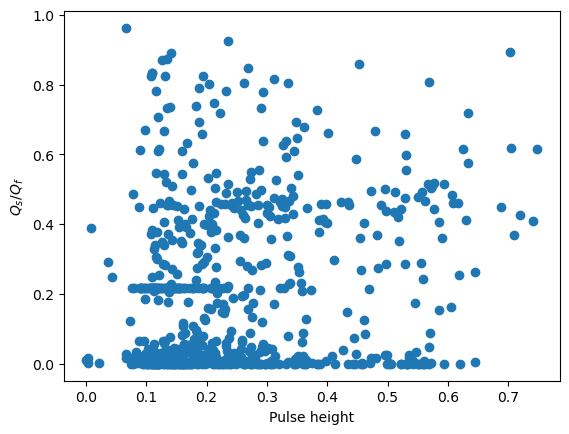

In [20]:
%matplotlib inline

QsOvSl = Qs_arr/Qf_arr

plt.scatter(amp_arr, QsOvSl)

# plt.xlim([-0.1, 2])
# plt.ylim(-0.01, 0.2)
plt.xlabel("Pulse height")
plt.ylabel("$Q_s/Q_f$")